# Convex hull as diagnostic tool in single-molecule localization microscopy
# Selection criterion size convex hull pt.I: Merged clusters
Here, the selection criterion via convex hull has the goal to identify merged clusters. This occurs more frequently at higher global density data (regarding cluster centres, i.e. fluorophores). In biological samples, merging can also occur if local densities are high due to underlying structures that lead to e.g. increased expression of monomers. 

In [1]:
import numpy as np
import pandas as pd
import colorcet as cc
import boost_histogram as bh

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

import src.convex_hull as ch
import src.simulations as si
import src.selection_criterion_merge as scmerge
from src.matplotlib_custom import second_axis_log, second_axis, pie_plot

### Load lookup table of area convex hull
Contains e.g. mean and standard deviation of areas of the convex hull.

In [2]:
lookup_table = pd.read_csv(r"lookup_tables\lookup_table_area_2d.csv", index_col=0)
mean = lookup_table.loc["$E(A_{ch}(n))$"].astype(float).values
std_pos = lookup_table.loc["$std_{pos}(n)$"].astype(float).values

Scale the values of the lookup table to the desired localization precision of the data simulation. In the case of the area, it is localization precision squared.

In [3]:
cluster_std = 8
max_areas_1sigma = (mean + std_pos)*cluster_std**2
max_areas_2sigma = (mean + 2*std_pos)*cluster_std**2
max_areas_3sigma = (mean + 3*std_pos)*cluster_std**2
max_areas_4sigma = (mean + 4*std_pos)*cluster_std**2
max_areas_5sigma = (mean + 5*std_pos)*cluster_std**2

## Evaluation of the method
Data is simulated, clustered and analyzed. The cluster's areas that exceed the applied threshold are the target of this method. They can be filtered out or stored elsewhere. 

Note: the threshold only applies to clusters that consist up to 200 samples. All clusters that exceed this value are targeted by this implementation no matter their area. 

In [4]:
parent_intensities = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 10e-5, 15e-5, 20e-5]
limits_ = si.limits(parent_intensities, 15e-5, 5000)
sim_param = dict(cluster_mu=9, cluster_std=8, min_samples=3, seed=np.random.default_rng(100))
alg_param = dict(eps=25, min_samples=3)
n_simulations = 30
max_areas = [max_areas_1sigma, max_areas_2sigma, max_areas_3sigma, max_areas_4sigma, max_areas_5sigma]
max_areas_keys = ["1 sigma", "2 sigma", "3 sigma", "4 sigma", "5 sigma"]
sca_means, sca_stds, sca_representation = scmerge.selection_criterion_analysis(n_simulations, parent_intensities, 
                                                                               limits_, sim_param, alg_param, 
                                                                               max_areas, max_areas_keys)
sca_representation.to_csv("csv_files\chc_merging_all.csv")
sca_means.to_csv("csv_files\chc_merging_means.csv")
sca_stds.to_csv("csv_files\chc_merging_stds.csv")

### The portion of merged clusters as identified by the clustering algorithm per cluster density
The merged clusters are the condition positives.

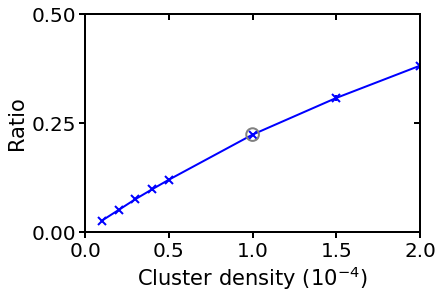

In [5]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = sca_means.index.levels[0]
x2 = x[5]
y = sca_means.loc[(slice(None), sca_means.index.levels[1][0]), "Algorithm merged clusters"].values
y2 = y[5]
yerr = sca_stds.loc[(slice(None), sca_stds.index.levels[1][0]), "Algorithm merged clusters"].values
ax.errorbar(x, y, yerr=yerr, lw=2, color="blue", zorder=1, marker="x", ms=8, mew=2, ecolor="blue")
ax.scatter(x2, y2, marker="o", color="grey", s=160, zorder=2, lw=2, facecolors="none")
ax.set_ylim(0, 0.5)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("Ratio", fontsize=21)
ax.set_xlabel("Cluster density (" + r"$10^{-4}$" + ")", fontsize=21)
ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax.set_xlim(0, 20e-5)
tick_spacing_x = 5e-5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.25
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.xaxis.get_offset_text().set_visible(False)
fig.savefig(r"plt_figures\merge_per_density.svg")

### The true positive rate TPR and false dicovery rate FDR with selection by convex hull

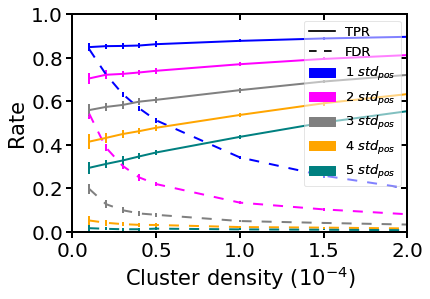

In [6]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = sca_means.index.levels[0]
color = ["blue", "magenta", "grey", "orange", "teal"]
patches = {}
for i, threshold in enumerate(sca_means.index.levels[1]):
    tpr = sca_means.loc[(slice(None), threshold), "TPR"].values
    tpr_yerr = sca_stds.loc[(slice(None), threshold), "TPR"].values
    fdr = sca_means.loc[(slice(None), threshold), "FDR"].values
    fdr_yerr = sca_stds.loc[(slice(None), threshold), "FDR"].values
    ax.errorbar(x, tpr, yerr=tpr_yerr, label=threshold, c=color[i], lw=2, marker="", markeredgewidth=2)
    ax.errorbar(x, fdr, yerr=fdr_yerr, ls=(0, (5, 5)), label=threshold, c=color[i], lw=2, marker="", 
                markeredgewidth=2)
    patches["patch{0}".format(i)] = mpatches.Patch(color=color[i], label=str(i+1) + r" $std_{pos}$")

handles_legend = [mlines.Line2D([], [], label="TPR", c="k", marker=""), 
                  mlines.Line2D([], [], label="FDR", linestyle=(0, (5, 5)), c="k", marker="")]
for patch in patches.values():
    handles_legend.append(patch)
second_legend = ax.legend(handles=handles_legend, loc=1, fontsize=13, framealpha=0.3)
ax.add_artist(second_legend)
ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax.set_xlabel("Cluster density (" + r"$10^{-4}$" + ")", fontsize=21)
ax.set_ylabel("Rate", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
ax.xaxis.get_offset_text().set_visible(False)
tick_spacing_x = 5e-5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0, 1)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(0, 20e-5)
fig.savefig(r"plt_figures\chc_merging_TPR_FDR.svg")

#### Representation in pie chart

In [7]:
densities = sca_means.index.levels[0]
thresholds = sca_means.index.levels[1]

density = densities[5]
threshold = thresholds[1]

condition_positive = merged = sca_means.loc[(density, threshold), "Algorithm merged clusters"]
condition_negative = 1 - condition_positive
TPR = sca_means.loc[(density, threshold), "TPR"]
TP = TPR * condition_positive
FN = condition_positive - TP
FDR = sca_means.loc[(density, threshold), "FDR"]
FP = FDR * TP / (1-FDR)
TN = condition_negative - FP

print(f"FP - {FP:.2f}, TP - {TP:.2f}, FN - {FN:.2f}, TN - {TN:.2f}")

FP - 0.03, TP - 0.17, FN - 0.05, TN - 0.75


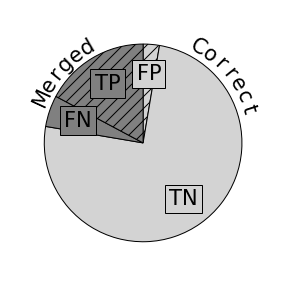

In [8]:
sizes = np.array([FP*100, TN*100, FN*100, TP*100])
labels = ["FP", "TN", "FN", "TP"]
colors = ["lightgrey", "lightgrey", "grey", "grey"]
hatches = ["//", "", "", "//"]
text_props = dict(size=21, va="center", ha="center", bbox=dict(boxstyle="square, pad=0.2"))
rounded_texts = ["Correct", None, "Merged", None]
wedgealignments = [30, None, 15, None]
startangle = 90
stretch = 0.6
rt_size = 21
rt_h_space = 7
rt_v_space = 1.02
radius = 2
labeldistance = 0.7

fig, ax = pie_plot(sizes, labels, colors, labeldistance, radius, text_props, hatches, rounded_texts, rt_size, rt_h_space,
                  rt_v_space, wedgealignments, stretch, startangle)
fig.savefig(r"plt_figures\chc_merging_pie_plot.svg")

### The true positive rate TPR and false dicovery rate FDR with selection by n

In [9]:
n_simulations = 30
parent_intensities = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 10e-5, 15e-5, 20e-5]
limits_ = si.limits(parent_intensities, 15e-5, 5000)
alg_param = dict(eps=25, min_samples=3)
sim_param = dict(cluster_mu=9, cluster_std=8, min_samples=3, seed=np.random.default_rng(100))
max_sample_counts = [10, 15, 20, 25, 30]
sample_count_means, sample_count_stds = scmerge.selection_by_sample_count(n_simulations, parent_intensities, limits_, 
                                                                          sim_param, alg_param, max_sample_counts)
np.save(file=r"npy_files\chc_merging_n_means.npy", arr=sample_count_means)
np.save(file=r"npy_files\chc_merging_n_stds.npy", arr=sample_count_stds)

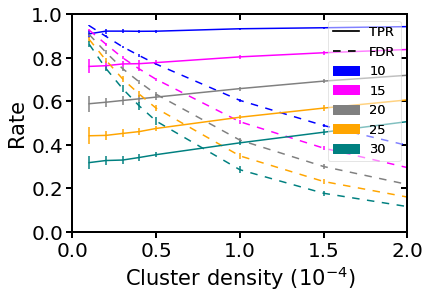

In [10]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = parent_intensities
color = ["blue", "magenta", "grey", "orange", "teal"]
patches = {}
for i, max_sample_count in enumerate(max_sample_counts):
    fdr = sample_count_means[:, i, 0]
    fdr_yerr = sample_count_stds[:, i, 0]
    tpr = sample_count_means[:, i, 1]
    tpr_yerr = sample_count_stds[:, i, 1]
    ax.errorbar(x, fdr, yerr=fdr_yerr, ls=(0, (5, 5)), c=color[i], marker="", markeredgewidth=2)
    ax.errorbar(x, tpr, yerr=tpr_yerr, c=color[i], marker="", markeredgewidth=2)
    patches["patch{0}".format(i)] = mpatches.Patch(color=color[i], label=max_sample_count)
handles_legend = [mlines.Line2D([], [], label="TPR", c="k", marker=""), 
                  mlines.Line2D([], [], label="FDR", linestyle=(0, (5, 5)), c="k", marker="")]
for patch in patches.values():
    handles_legend.append(patch)
second_legend = ax.legend(handles=handles_legend, loc=1, fontsize=13, framealpha=0.3)
ax.add_artist(second_legend)
ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax.set_xlabel("Cluster density (" + r"$10^{-4}$" + ")", fontsize=21)
ax.set_ylabel("Rate", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
ax.xaxis.get_offset_text().set_visible(False)
tick_spacing_x = 5e-5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0, 1)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(0, 20e-5)
fig.savefig(r"plt_figures\chc_merging_TPR_FDR_n.svg")

#### Representation in pie chart

In [11]:
densities = sca_means.index.levels[0]

density = densities[5]

# condition positive can be extracted from sca_means dataframe, since the simulated data and their clustering 
# is the same due to identical seeds
condition_positive = merged = sca_means.loc[(density, slice(None)), "Algorithm merged clusters"].values[0]
condition_negative = 1 - condition_positive
TPR = sample_count_means[5, 1, 1]
TP = TPR * condition_positive
FN = condition_positive - TP
FDR = sample_count_means[5, 1, 0]
FP = FDR * TP / (1-FDR)
TN = condition_negative - FP

print(f"FP - {FP:.2f}, TP - {TP:.2f}, FN - {FN:.2f}, TN - {TN:.2f}")

FP - 0.18, TP - 0.18, FN - 0.04, TN - 0.59


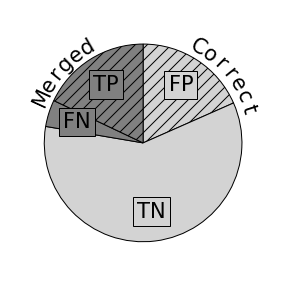

In [12]:
sizes = np.array([FP*100, TN*100, FN*100, TP*100])
labels = ["FP", "TN", "FN", "TP"]
colors = ["lightgrey", "lightgrey", "grey", "grey"]
hatches = ["//", "", "", "//"]
text_props = dict(size=21, va="center", ha="center", bbox=dict(boxstyle="square, pad=0.2"))
rounded_texts = ["Correct", None, "Merged", None]
wedgealignments = [30, None, 15, None]
startangle = 90
stretch = 0.6
rt_size = 21
rt_h_space = 7
rt_v_space = 1.02
radius = 2
labeldistance = 0.7

fig, ax = pie_plot(sizes, labels, colors, labeldistance, radius, text_props, hatches, rounded_texts, rt_size, rt_h_space,
                   rt_v_space, wedgealignments, stretch, startangle)
fig.savefig(r"plt_figures\chc_merging_pie_plot_n.svg")

### 2D Histograms of the area of the convex hull per n. 
Left side: Cluster density of 1e-5\
Right: Cluster density of 10e-5

Top to bottom: Simulation (ground truth), DBSCAN result, DBSCAN result post-filtering, merged clusters (condition positives). 

In [13]:
parent_intensity_1 = [1e-5]
limits_1 = si.limits(parent_intensity_1, 15e-5, 5000)
sim_param1 = dict(cluster_mu=9, cluster_std=8, lower_limit=-limits_1[0], upper_limit=limits_1[0], min_samples=3, 
                 seed=np.random.default_rng(100))
parent_intensity_2 = [10e-5]
limits_2 = si.limits(parent_intensity_2, 15e-5, 5000)
sim_param2 = dict(cluster_mu=9, cluster_std=8, lower_limit=-limits_2[0], upper_limit=limits_2[0], min_samples=3, 
                 seed=np.random.default_rng(100))
alg_param = dict(eps=25, min_samples=3)
max_area = max_areas_2sigma
simulation_1, algorithm_1, post_selection_1, merged_1 = scmerge.visualization_selection(parent_intensity_1[0], 
                                                                                        sim_param1,
                                                                                        alg_param, max_area)
simulation_2, algorithm_2, post_selection_2, merged_2 = scmerge.visualization_selection(parent_intensity_2[0], 
                                                                                        sim_param2,
                                                                                        alg_param, max_area)

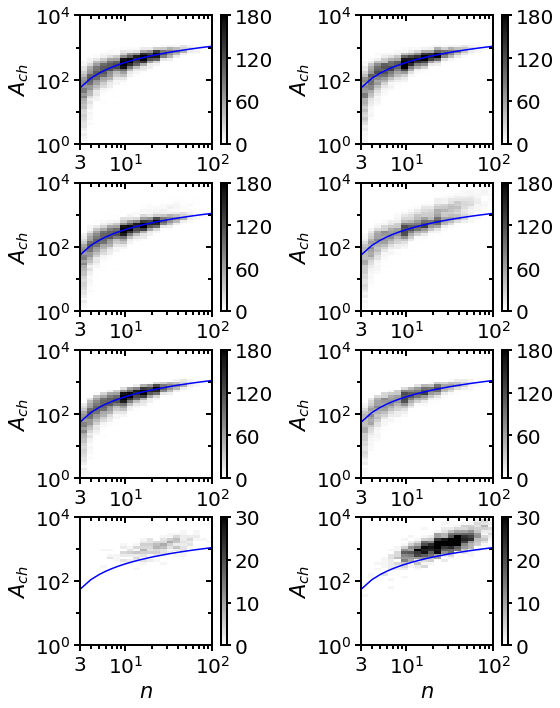

In [14]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(4, 2, figsize=(8, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.7, top=1)
n = np.linspace(3, 100, 98)
axes = bh.axis.AxesTuple((
    bh.axis.Regular(20, 3, 103, transform=bh.axis.transform.log),
    bh.axis.Regular(50, 1, 15000, transform=bh.axis.transform.log)
))
histogram = bh.Histogram(*axes)
y = [simulation_1, algorithm_1, post_selection_1, merged_1,
       simulation_2, algorithm_2, post_selection_2, merged_2]
vmax = [180, 180, 180, 30, 180, 180, 180, 30]
cbar_spacing = [60, 60, 60, 10, 60, 60, 60, 10]
axeses = np.concatenate((ax[:, 0], ax[:, 1]))

for i, axis in enumerate(axeses):
    histogram.reset()
    histogram.fill(*y[i])
    mesh = axis.pcolormesh(*histogram.axes.edges.T, histogram.view().T, vmin=0, vmax=vmax[i], 
                           cmap=cc.m_gray.reversed(), zorder=0)
    cbar = fig.colorbar(mesh, ax=axis)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(cbar_spacing[i]))
    cbar.ax.tick_params(width=2, length=4, labelsize=20)
    axis.plot(n, ch.calc_area_convex_hull_2d_pt2(8, n), "-", color="b")
    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_ylabel(r"$A_{ch}$", fontsize=21)
    axis.set_xlabel(r"$n$", fontsize=21)
    tick_spacing_x = 10
    axis.xaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_x))
    tick_spacing_y = 100
    axis.yaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_y))
    axis.tick_params(labelsize=20, width=2, length=6)
    axis.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(1., 10.), base=10))
    axis.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(2., 3., 4., 5., 6., 7., 8., 9.), base=10))
    axis.tick_params(which="minor", width=2, length=4, labelleft=False, left=True)
    second_axis_log(axis, "top", tick_spacing_x)
    second_axis_log(axis, "right", tick_spacing_y)
    axis.set_ylim(1, 1e4)
    xtick = axis.get_xticks()
    np.append(xtick, [3])
    xtick[-1] = 3
    labels = [item.get_text() for item in axis.get_xticklabels()]
    for i in range(len(xtick)):
        l = int(np.log10(xtick[i]))
        labels[i] = r"$10^{}$".format(l)
    labels[-1] = "3"
    axis.set_xticks(xtick)
    axis.set_xticklabels(labels)
    axis.set_xlim(3, 1e2)

fig.savefig(r"plt_figures\chc_merging_2D_histograms.svg")

## The distribution of n per cluster of merged vs. non-merged clusters

In [15]:
alg_param = dict(eps=25, min_samples=3)
sim_param = dict(cluster_mu=9, cluster_std=8, lower_limit=-5000, upper_limit=5000, min_samples=3,
                 seed=np.random.default_rng(100), parent_intensity=10e-5)
n_simulations = 10
x1, x2 = scmerge.merged_cluster_sizes_comparison(n_simulations, sim_param, alg_param)

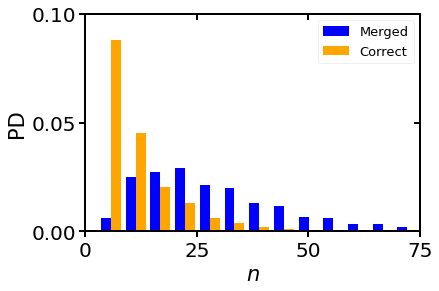

In [16]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(x=[x1,x2], bins=30, density=True, 
           label=["Merged", "Correct"], color=["blue", "orange"])
ax.set_xlim(0, 75)
tick_spacing_x = 25
tick_spacing_y = 0.05
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.tick_params(labelsize=20, width=2, length=6)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlabel("$n$", fontsize=21)
ax.set_ylabel("PD", fontsize=21)
ax.set_ylim(0, 0.1)
ax.legend(loc=1, fontsize=13, framealpha=0.3)
fig.savefig(r"plt_figures\chc_merging_n_merg_vs_non_merg.svg")